# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
#        if np.any(dones):                                  # exit loop if episode finished
#            break
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
env_info = env.reset(train_mode=True)[brain_name]

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import copy
from collections import namedtuple, deque
from datetime import datetime

In [9]:
BUFFER_SIZE = int(1e6)      # replay buffer size
BATCH_SIZE = 1024        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 3e-3        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay
LATERAL_LIMIT = 1
JUMP_LIMIT_MAX = 1
JUMP_LIMIT_MIN = 0
ACTOR_FC1_UNITS=128
ACTOR_FC2_UNITS=64
ACTOR_FC3_UNITS=32

CRITIC_FC1_UNITS=128
CRITIC_FC2_UNITS=64
CRITIC_FC3_UNITS=32

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

experience_type = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [10]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=ACTOR_FC1_UNITS, fc2_units=ACTOR_FC2_UNITS, fc3_units=ACTOR_FC3_UNITS):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)
        self.fc2_small = nn.Linear(fc1_units, action_size)
        self.fc3_small = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        self.fc2_small.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3_small.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        return F.tanh(self.fc2_small(x))
        #x = F.relu(self.fc2(x))
        #return F.tanh(self.fc3_small(x))
        #x = F.relu(self.fc3(x))
        #return F.tanh(self.fc4(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=CRITIC_FC1_UNITS, fc2_units=CRITIC_FC2_UNITS,  fc3_units=ACTOR_FC3_UNITS):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.fc3_small = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3_small.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action, dim=1):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.fcs1(state))      
        x = torch.cat((xs, action), dim=dim)
        x = F.leaky_relu(self.fc2(x))
        #return F.tanh(self.fc3_small(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [11]:
# SumTree : https://github.com/rlcode/per/blob/master/SumTree.py
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity, obj_type):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        #self.data = np.zeros(capacity, dtype=obj_type)
        self.data = [ obj_type(np.zeros(state_size), np.zeros(action_size), 0,np.zeros(state_size), 0) for i in range(capacity) ]
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[dataIdx])

In [12]:
class Memory:  # stored as ( s, a, r, s_ ) in SumTree : https://github.com/rlcode/per/blob/master/prioritized_memory.py
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity, obj_type):
        self.tree = SumTree(capacity, obj_type)
        self.capacity = capacity

    def _get_priority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)
        
    def __len__(self):
        return self.tree.n_entries
        
    def sample(self, n = BATCH_SIZE):
        batch = []
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)
            

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)

In [13]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, replay_buffer=None, actor_local=None, actor_target=None, critic_local=None, critic_target=None):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        if actor_local == None:
            self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        else:
            self.actor_local  = actor_local
            
        if actor_target == None:
            self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        else:
            self.actor_target = actor_target
                 
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        if critic_local == None:
            self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        else:
            self.critic_local = critic_local
        
        if critic_target == None:
            self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        else:
            self.critic_target = critic_target
            
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        if replay_buffer == None:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, experience_type, False)
        else:
            self.memory = replay_buffer
    
    def step(self, states, actions, rewards, next_states, dones, time, common_agent_used):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        t_next_states = torch.from_numpy(np.array(next_states)).float().to(device)
        t_states      = torch.from_numpy(np.array(states     )).float().to(device)
        t_rewards     = torch.from_numpy(np.array(rewards    )).float().to(device)
        t_actions     = torch.from_numpy(np.array(actions    )).float().to(device)
        
        if common_agent_used == True:   
            for state, action, reward, next_state, done, t_state, t_action, t_reward, t_next_state in zip(states, actions, rewards, next_states, dones, t_states, t_actions, t_rewards, t_next_states):
                t_action_next = self.actor_target(t_next_state)
                Q_expected = self.critic_local(t_state, t_action, 0)
                Q_target_next = self.critic_target(t_next_state, t_action_next, 0)
                Q_target = t_reward + (GAMMA * Q_target_next * (1 - done))
                error = torch.abs(Q_expected - Q_target).data.cpu().numpy()
                
                self.memory.add(error, state, action, reward, next_state, done)
        else:
            actions_next = self.actor_target(next_states)
            Q_expected = self.critic_local(states, actions)
            Q_targets_next = self.critic_target(next_states, actions_next)
            Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
            error = torch.abs(Q_expected - Q_targets).data.cpu().numpy()            
            self.memory.add(error, states, actions, rewards, next_states, dones)
            

        # Learn, if enough samples are available in memory        
        if time %2 == 0:
            if len(self.memory) > BATCH_SIZE:
                for i in range(1):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA, common_agent_used)
            
            

    def act(self, state, common_agent_used, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()        
        self.actor_local.train()
               
        if add_noise:
            noise  = self.noise.sample()
            action += noise
        
        if common_agent_used == True:
            for i in range(len(action)):
                action[i][0] = np.clip(action[i][0],-LATERAL_LIMIT, LATERAL_LIMIT)
                action[i][1] = np.clip(np.fabs(action[i][1]),JUMP_LIMIT_MIN, JUMP_LIMIT_MAX)
        else:
            action[0] = np.clip(action[0], -LATERAL_LIMIT, LATERAL_LIMIT)
            action[1] = np.clip(np.fabs(action[1]), JUMP_LIMIT_MIN, JUMP_LIMIT_MAX)

         
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, common_agent_used):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones, ids, is_weight = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
        # ----------------------- update PER ----------------------------------- #
        if ids is not None:
            error_vec = torch.abs(Q_expected - Q_targets).data.cpu().numpy()
        
            for i in range(len(ids)):
                self.memory.update(error_vec[i], ids[i])

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([(random.random() - 0.5) for i in range(len(x))])
        self.state = x + dx
        return self.state
        #return x + dx

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, obj_type, prioritized_replay):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.prioritized_replay = prioritized_replay
        if False == self.prioritized_replay:
            self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        else:
            self.memory = Memory(buffer_size, obj_type)
        self.experience = obj_type
        self.batch_size = batch_size        
        self.seed = random.seed(seed)
    
    def add(self, error, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        if False == self.prioritized_replay:
            self.memory.append(e)
        else:
            self.memory.add(error, e)
    
    def update(self, error, idx):
        if self.prioritized_replay:
            self.memory.update(idx, error)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""        
        if False == self.prioritized_replay:
            experiences = random.sample(self.memory, k=self.batch_size)
            ids = None
            is_weight = None
        else:
            experiences, ids, is_weight = self.memory.sample(n = self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones, ids, is_weight)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [14]:
import gym
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
random_seed = 4
priority_replay = True
common_replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed, experience_type, priority_replay)
common_actor_local   = Actor(state_size, action_size, random_seed).to(device)
common_actor_target  = Actor(state_size, action_size, random_seed).to(device)
common_critic_local  = Critic(state_size, action_size, random_seed).to(device)
common_critic_target = Critic(state_size, action_size, random_seed).to(device)

sharing_configurations = {
    'NO_SHARING':{'replay_buffer':None,'actor_local':None,'actor_target':None,'critic_local':None,'critic_target':None},
    'REPLAY_SHARE':{'replay_buffer':common_replay_buffer,'actor_local':None,'actor_target':None,'critic_local':None,'critic_target':None},
    'ACTOR_SHARE':{'replay_buffer':common_replay_buffer,'actor_local':common_actor_local,'actor_target':common_actor_target,'critic_local':None,'critic_target':None},
    'CRITIC_SHARE':{'replay_buffer':common_replay_buffer,'actor_local':None,'actor_target':None,'critic_local':common_critic_local,'critic_target':common_critic_target},
    'ALL_SHARE':{'replay_buffer':common_replay_buffer,'actor_local':common_actor_local,'actor_target':common_actor_target,'critic_local':common_critic_local,'critic_target':common_critic_target},
}

current_share_configuration = sharing_configurations['ALL_SHARE']

agents = [Agent(state_size=state_size, action_size=action_size,
                random_seed=random_seed, 
                replay_buffer=current_share_configuration['replay_buffer'],
                actor_local=current_share_configuration['actor_local'],
                actor_target=current_share_configuration['actor_target'],
                critic_local=current_share_configuration['critic_local'],
                critic_target=current_share_configuration['critic_target']
               ) for x in range(num_agents)]

common_agent = Agent(state_size=state_size, action_size=action_size,
                random_seed=random_seed, 
                replay_buffer=current_share_configuration['replay_buffer'],
                actor_local=current_share_configuration['actor_local'], 
                actor_target=current_share_configuration['actor_target'],
                critic_local=current_share_configuration['critic_local'], 
                critic_target=current_share_configuration['critic_target']
               )

In [16]:
def save_model(agent, name):
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_pri_replay_2_{}.pth'.format(name))
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_pri_replay_2_{}.pth'.format(name))

In [17]:
def ddpg(n_episodes=20000, max_t=3000, print_every=25, common_agent_used=False):
    scores_deque = deque(maxlen=100)
    scores = []
    average_scores = []
    episode_number = 0
    max_score = 0
    no_change_in_max_score_count = 0
    achieved_threshold = False
    max_average_score = -1
    try:
        for i_episode in range(1, n_episodes+1):
            episode_number = i_episode
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            score_agents = []
            if common_agent_used == False:
                score_agents = [0 for agent in agents]
            score_per_episode = [0, 0]
            
            if common_agent_used == False:
                for i in range(len(agents)):
                    agents[i].reset()
            else:
                common_agent.reset()
                
            for t in range(max_t):
                actions = np.zeros((num_agents, action_size))
                if common_agent_used == False:
                    actions = [agent.act(state, False) for agent,state in zip(agents,states)]
                else:
                    actions = [common_agent.act(state, False) for state in states]
                    #actions[0] = common_agent.act(states[0], True)
                    #actions[1] = common_agent.act(states[1], True)                    
                
                env_info = env.step(actions)[brain_name]
                
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                
                if(t % 1 == 0):
                    if common_agent_used == False:
                        for i in range(len(agents)):
                            agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i], t, common_agent_used)
                        for i in range(len(score_agents)):
                            score_agents[i] += np.sum(rewards[i])
                    else:
                        common_agent.step(states, actions, rewards, next_states, dones, t, common_agent_used)
                        score_per_episode[0] += rewards[0]
                        score_per_episode[1] += rewards[1]
                        
                    
                states = next_states
            
                if np.any(dones):
                    break 
                    
            prev_max_score = max_score
            if common_agent_used == False:
                max_score = np.amax(score_agents)
            else:
                max_score = np.amax(score_per_episode)

            if(prev_max_score == max_score):
                no_change_in_max_score_count = no_change_in_max_score_count + 1
            else:
                no_change_in_max_score_count = 0
            
            scores_deque.append(max_score)
            scores.append(max_score)        
            average_score = np.mean(scores_deque)
            average_scores.append(average_score)
            
            update_string = '\rEpisode {}\tAverage Score: {:.4f} : Max Score : {:.4f} : Time : {}'
            print(update_string.format(i_episode, average_score, max_score, datetime.now().time()), end="")
            
            if i_episode % print_every == 0:
                if (achieved_threshold == False):
                    if common_agent_used == False:
                        [save_model(agent, i) for i, agent in enumerate(agents)]
                    else:
                        save_model(common_agent,0)
                print(update_string.format(i_episode, np.mean(scores_deque), max_score, datetime.now().time()))
            
            if average_score >= 0.5:
                achieved_threshold = True
                if(average_score > max_average_score):
                    max_average_score = average_score
                    if common_agent_used == False:
                        [save_model(agent, i) for i, agent in enumerate(agents)]
                    else:
                        save_model(common_agent,0)
                    print('\r\nAverage score {} crossed 0.5 at Episode {}'.format(average_score, i_episode))
                
            if (no_change_in_max_score_count >= 8000) and (i_episode > 200):
                print('\r\nNo change in max score detected for {} episodes, ending run'.format(no_change_in_max_score_count))
                break
    except KeyboardInterrupt:
        print('\nDetected Keyboard interrupt, returning after episide {}'.format(episode_number))
        return scores, average_scores, episode_number
            
            
    return scores, average_scores, episode_number


In [18]:
scores, average_scores, episodes_run = ddpg(common_agent_used=True)

Episode 25	Average Score: 0.0040 : Max Score : 0.0000 : Time : 13:08:29.741900
Episode 38	Average Score: 0.0026 : Max Score : 0.0000 : Time : 13:08:34.971923

/home/anoop/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in power
/home/anoop/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Episode 50	Average Score: 0.0020 : Max Score : 0.0000 : Time : 13:08:42.716515
Episode 75	Average Score: 0.0013 : Max Score : 0.0000 : Time : 13:08:59.003254
Episode 100	Average Score: 0.0010 : Max Score : 0.0000 : Time : 13:09:15.225552
Episode 125	Average Score: 0.0000 : Max Score : 0.0000 : Time : 13:09:31.640800
Episode 150	Average Score: 0.0000 : Max Score : 0.0000 : Time : 13:09:48.180552
Episode 175	Average Score: 0.0000 : Max Score : 0.0000 : Time : 13:10:04.657554
Episode 200	Average Score: 0.0000 : Max Score : 0.0000 : Time : 13:10:21.141494
Episode 225	Average Score: 0.0000 : Max Score : 0.0000 : Time : 13:10:38.079247
Episode 250	Average Score: 0.0000 : Max Score : 0.0000 : Time : 13:10:54.507137
Episode 275	Average Score: 0.0000 : Max Score : 0.0000 : Time : 13:11:11.391162
Episode 300	Average Score: 0.0000 : Max Score : 0.0000 : Time : 13:11:27.730434
Episode 325	Average Score: 0.0038 : Max Score : 0.0000 : Time : 13:11:46.702839
Episode 350	Average Score: 0.0038 : Max Sc

Episode 2575	Average Score: 0.0882 : Max Score : 0.1000 : Time : 14:12:00.744527
Episode 2600	Average Score: 0.0836 : Max Score : 0.1000 : Time : 14:12:35.723038
Episode 2625	Average Score: 0.0791 : Max Score : 0.1000 : Time : 14:13:13.752292
Episode 2650	Average Score: 0.0829 : Max Score : 0.1000 : Time : 14:13:58.147863
Episode 2675	Average Score: 0.0820 : Max Score : 0.0000 : Time : 14:14:42.791756
Episode 2700	Average Score: 0.0655 : Max Score : 0.0000 : Time : 14:15:01.967341
Episode 2725	Average Score: 0.0454 : Max Score : 0.0000 : Time : 14:15:18.979966
Episode 2750	Average Score: 0.0248 : Max Score : 0.0000 : Time : 14:15:35.962263
Episode 2775	Average Score: 0.0030 : Max Score : 0.0000 : Time : 14:15:53.101769
Episode 2800	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:16:10.319580
Episode 2825	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:16:27.561515
Episode 2850	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:16:44.525505
Episode 2875	Average Score: 

Episode 5100	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:56:06.392512
Episode 5125	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:56:23.297932
Episode 5150	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:56:40.014604
Episode 5175	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:56:56.806648
Episode 5200	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:57:13.542950
Episode 5225	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:57:30.306736
Episode 5250	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:57:46.998552
Episode 5275	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:58:03.924436
Episode 5300	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:58:21.309203
Episode 5325	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:58:38.592603
Episode 5350	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:58:55.806901
Episode 5375	Average Score: 0.0000 : Max Score : 0.0000 : Time : 14:59:13.041166
Episode 5400	Average Score: 

Episode 7625	Average Score: 0.0618 : Max Score : 0.1000 : Time : 15:34:01.535012
Episode 7650	Average Score: 0.0627 : Max Score : 0.1000 : Time : 15:34:42.666214
Episode 7675	Average Score: 0.0597 : Max Score : 0.0000 : Time : 15:35:21.199762
Episode 7700	Average Score: 0.0607 : Max Score : 0.1000 : Time : 15:36:05.597061
Episode 7725	Average Score: 0.0586 : Max Score : 0.1000 : Time : 15:36:49.931343
Episode 7750	Average Score: 0.0607 : Max Score : 0.2000 : Time : 15:37:37.764352
Episode 7775	Average Score: 0.0677 : Max Score : 0.0000 : Time : 15:38:26.689355
Episode 7800	Average Score: 0.0688 : Max Score : 0.1000 : Time : 15:39:16.624083
Episode 7825	Average Score: 0.0660 : Max Score : 0.1000 : Time : 15:39:53.887445
Episode 7850	Average Score: 0.0640 : Max Score : 0.1000 : Time : 15:40:35.081030
Episode 7875	Average Score: 0.0559 : Max Score : 0.1000 : Time : 15:41:09.286854
Episode 7900	Average Score: 0.0469 : Max Score : 0.0000 : Time : 15:41:42.680800
Episode 7925	Average Score: 

Episode 10150	Average Score: 0.0707 : Max Score : 0.1000 : Time : 16:34:15.088617
Episode 10175	Average Score: 0.0738 : Max Score : 0.1000 : Time : 16:35:03.659308
Episode 10200	Average Score: 0.0727 : Max Score : 0.0000 : Time : 16:35:48.779807
Episode 10225	Average Score: 0.0757 : Max Score : 0.0000 : Time : 16:36:33.363388
Episode 10250	Average Score: 0.0747 : Max Score : 0.2000 : Time : 16:37:17.955147
Episode 10275	Average Score: 0.0647 : Max Score : 0.1000 : Time : 16:37:54.859358
Episode 10300	Average Score: 0.0668 : Max Score : 0.0000 : Time : 16:38:37.637147
Episode 10325	Average Score: 0.0698 : Max Score : 0.0000 : Time : 16:39:27.350216
Episode 10350	Average Score: 0.0715 : Max Score : 0.0000 : Time : 16:40:09.537534
Episode 10375	Average Score: 0.0785 : Max Score : 0.0000 : Time : 16:41:00.086733
Episode 10400	Average Score: 0.0745 : Max Score : 0.1000 : Time : 16:41:44.079803
Episode 10425	Average Score: 0.0724 : Max Score : 0.1000 : Time : 16:42:31.480499
Episode 10450	Av

Episode 12625	Average Score: 0.1517 : Max Score : 0.1000 : Time : 18:08:16.873108
Episode 12650	Average Score: 0.1449 : Max Score : 0.1000 : Time : 18:09:25.955824
Episode 12675	Average Score: 0.1307 : Max Score : 0.0000 : Time : 18:10:25.212589
Episode 12700	Average Score: 0.1210 : Max Score : 0.1000 : Time : 18:11:28.401308
Episode 12725	Average Score: 0.1169 : Max Score : 0.1000 : Time : 18:12:15.942863
Episode 12750	Average Score: 0.1248 : Max Score : 0.5000 : Time : 18:13:36.158313
Episode 12775	Average Score: 0.1407 : Max Score : 0.2000 : Time : 18:14:58.999501
Episode 12800	Average Score: 0.1507 : Max Score : 0.1900 : Time : 18:16:14.381163
Episode 12825	Average Score: 0.1667 : Max Score : 0.1000 : Time : 18:17:38.724765
Episode 12850	Average Score: 0.1588 : Max Score : 0.1000 : Time : 18:18:43.595121
Episode 12875	Average Score: 0.1546 : Max Score : 0.1000 : Time : 18:19:59.210175
Episode 12900	Average Score: 0.1396 : Max Score : 0.1000 : Time : 18:20:51.121426
Episode 12925	Av

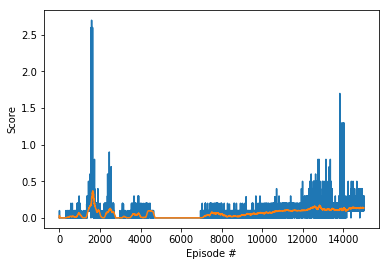

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(np.arange(1, len(scores)+1), average_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

1000000
[0.61032414 1.        ]


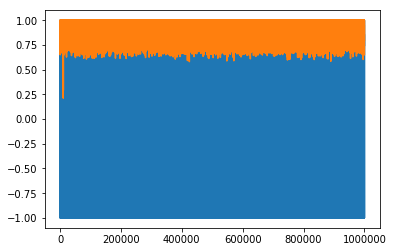

In [20]:
print(len(common_replay_buffer.memory.tree.data))
fig = plt.figure()
actions = []

for exp in common_replay_buffer.memory.tree.data:
    if exp.action.dtype == 'float32' or  exp.action.dtype == 'float64' :
        actions.append(exp.action)
    else:
        try:
            actions.append(exp.action.data.detach().cpu().numpy())
        except AttributeError:
            print(exp.action.dtype)

print(actions[200])
#print(common_replay_buffer.memory.tree.data[0])
plt.plot(np.arange(0, len(actions)),actions)

In [21]:
env.close()

In [22]:
a,b,c = common_replay_buffer.memory.sample(20)
#print(b)
print(c)

[0.39104055 0.36586287 0.67810381 0.49246554 0.88464866 0.55256456
 0.35631176 1.         0.44124092 0.32190179 0.26073961 0.30033438
 0.24073251 0.25515046 0.83510142 0.32708014 0.41645744 0.35217808
 0.56186531 0.22932677]
